In [1]:
import cv2

# img = cv2.imread('images/solar_Fri_Jun_16_6__0__25_2017_L_0.0901960784314_I_0.003.jpg')
img=cv2.imread('images/tree.jpg')
# img=cv2.imread('images/out3.jpg')

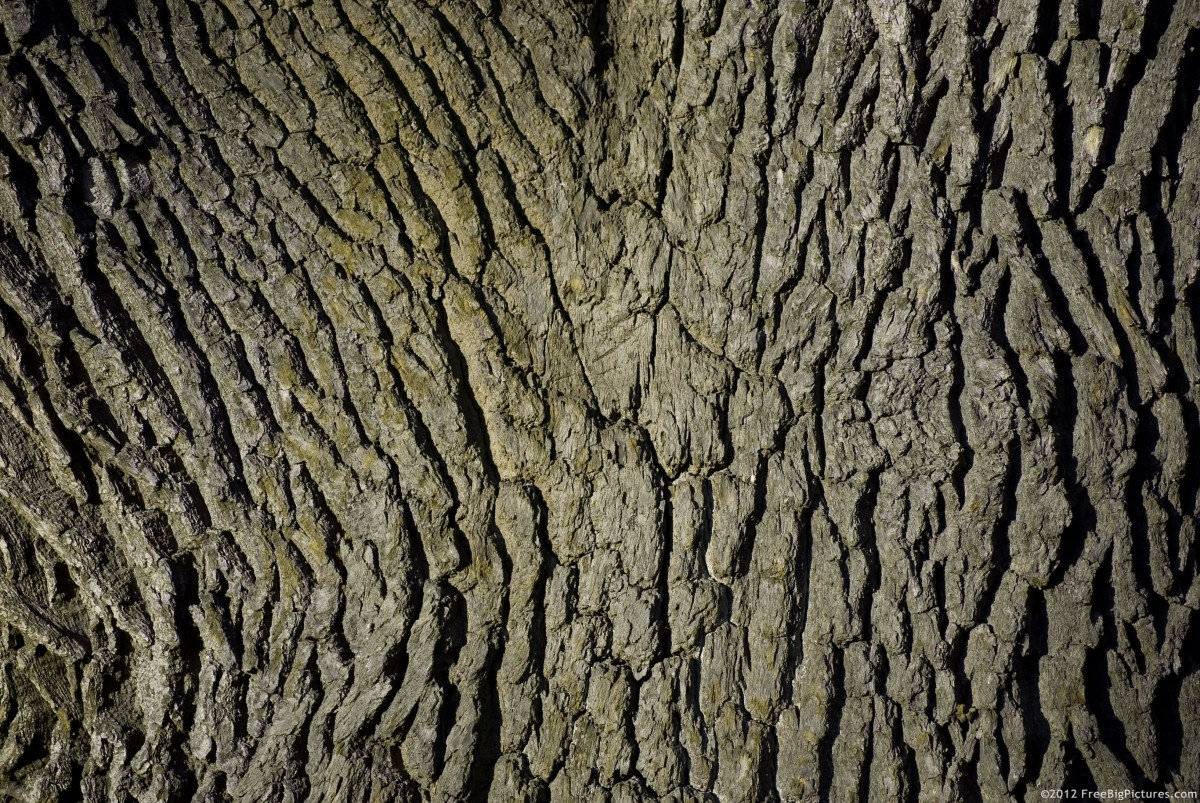

(803, 1200, 3)

In [2]:
import IPython

def imshow(img):
    returnValue, buffer = cv2.imencode('.jpg', img)
    IPython.display.display(IPython.display.Image(data=buffer.tobytes()))

imshow(img)

height, width, channels = img.shape
img.shape

In [3]:
import numpy as np
import time

def ps_filter(img):
    #Sobel Hor filter  
    kernelV    = np.array([[-1.0,-2.0,-1.0],[0.0,0.0,0.0],[1.0,2.0,1.0]],np.float32)
    kernelH    = np.array([[1.0,2.0,1.0],[0.0,0.0,0.0],[-1.0,-2.0,-1.0]],np.float32)
    kernelG    = np.array([[1.0,2.0,1.0],[2.0,4.0,2.0],[1.0,2.0,1.0]],np.float32)
    kernelD   = np.ones((3,3),np.uint8)
    buf       = np.ones((height,width),np.uint8)
    frame_out = np.ones((height,width),np.uint8)

    num_frames    = 20

    gaussian_kernel = cv2.getGaussianKernel(5,3)
#     print(gaussian_kernel)
    # kernel_2D = gaussian_kernel @ gaussian_kernel.transpose()

    start = time.time()
    frame_in_gray = cv2.cvtColor(img,cv2.COLOR_RGB2GRAY)
    # cv2.filter2D(img, -1, kernelG, buf, borderType=cv2.BORDER_CONSTANT)
    blurred=cv2.filter2D(img, -1, gaussian_kernel)
#     cv2.dilate(buf, kernelD, frame_out, borderType=cv2.BORDER_CONSTANT)
#     imshow(blurred)

    time_sw_total = time.time() - start
    print("Time Taken: {} ".format(time_sw_total))

In [4]:
# print(open('prunSW','r').read())
# res = !cat prunSW | grep filter2D | awk '{{print $$2}}'
# tottime_sw_filter2d = float(res[0])
# res = !cat prunSW | grep dilate   | awk '{{print $$2}}'
# tottime_sw_dilate   = float(res[0])

In [5]:
import cv2 #NOTE: This needs to be loaded first

# Load filter2D + dilate overlay
from pynq import Overlay
bs = Overlay("/usr/local/lib/python3.6/dist-packages/pynq_cv/overlays/xv2Filter2DDilate.bit")
bs.download()
import pynq_cv.overlays.xv2Filter2DDilate as xv2

# Load xlnk memory manager
from pynq import Xlnk
Xlnk.set_allocator_library('/usr/local/lib/python3.6/dist-packages/pynq_cv/overlays/xv2Filter2DDilate.so')
mem_manager = Xlnk()

In [6]:
import numpy as np
import time
import multiprocessing
from multiprocessing.pool import ThreadPool

def stream_fpga_filter(img):
    kernelF    = np.array([[1.0,2.0,1.0],[0.0,0.0,0.0],[-1.0,-2.0,-1.0]],np.float32)
    kernelVoid = np.zeros(0)
    xFin       = mem_manager.cma_array((height,width),np.uint8)
    xFbuf      = mem_manager.cma_array((height,width),np.uint8)
    xFout      = mem_manager.cma_array((height,width),np.uint8)

#     num_frames       = 20

#     xFin[:]    = frame_in_gray[:]
    start = time.time()
    for _ in range(10):
        frame_in_gray = cv2.cvtColor(img,cv2.COLOR_RGB2GRAY)
        xFin[:]       = frame_in_gray[:]
        
        xv2.filter2D(xFin, -1, kernelF, xFbuf, borderType=cv2.BORDER_CONSTANT)
        xv2.dilate(xFbuf, kernelVoid, xFout, borderType=cv2.BORDER_CONSTANT)
        
#         frame_out[:]  = xFout[:]
#         imshow(xFout[:])
    time_hw_total = time.time() - start
    print("Time Taken:  " + str(time_hw_total))

def fpga_filter(img):
    kernelF    = np.array([[1.0,2.0,1.0],[0.0,0.0,0.0],[-1.0,-2.0,-1.0]],np.float32)
    kernelVoid = np.zeros(0)
    xFin       = mem_manager.cma_array((height,width),np.uint8)
    xFbuf      = mem_manager.cma_array((height,width),np.uint8)
    xFout      = mem_manager.cma_array((height,width),np.uint8)

#     num_frames       = 20

#     xFin[:]    = frame_in_gray[:]
    start = time.time()
    frame_in_gray = cv2.cvtColor(img,cv2.COLOR_RGB2GRAY)
    xFin[:]       = frame_in_gray[:]

    xv2.filter2D(xFin, -1, kernelF, xFbuf, borderType=cv2.BORDER_CONSTANT)
    xv2.dilate(xFbuf, kernelVoid, xFout, borderType=cv2.BORDER_CONSTANT)

#         frame_out[:]  = xFout[:]
#         imshow(xFout[:])
    time_hw_total = time.time() - start
    print("Time Taken:  " + str(time_hw_total))

# Single Processing: 

In [7]:
print('time taken for big image')
num_iterations=10
print("Time taken on PS with Single Processing for {} Iterations".format(num_iterations))
start_time=time.time()
for i in range(num_iterations):
    ps_filter(img)
print('Time taken for non-parallel execution: {}'.format(time.time()-start_time))

num_iterations=10
print("Time taken on FPGA with stream Single Processing for {} Iterations".format(num_iterations))
start_time=time.time()
# for i in range(num_iterations):
stream_fpga_filter(img)
print('Time taken for non-parallel execution: {}'.format(time.time()-start_time))

print("Time taken on FPGA with stream Single Processing for {} Iterations".format(num_iterations))
start_time=time.time()
for i in range(num_iterations):
    fpga_filter(img)
print('Time taken for non-parallel execution: {}'.format(time.time()-start_time))


time taken for big image
Time taken on PS with Single Processing for 10 Iterations
Time Taken: 0.18195033073425293 
Time Taken: 0.10009145736694336 
Time Taken: 0.09964823722839355 
Time Taken: 0.10012960433959961 
Time Taken: 0.10066604614257812 
Time Taken: 0.10020875930786133 
Time Taken: 0.09971308708190918 
Time Taken: 0.09967803955078125 
Time Taken: 0.09968709945678711 
Time Taken: 0.09997844696044922 
Time taken for non-parallel execution: 1.1078193187713623
Time taken on FPGA with stream Single Processing for 10 Iterations
Time Taken:  0.11426353454589844
Time taken for non-parallel execution: 0.12965178489685059
Time taken on FPGA with stream Single Processing for 10 Iterations
Time Taken:  0.011379241943359375
Time Taken:  0.011411190032958984
Time Taken:  0.01136469841003418
Time Taken:  0.011476516723632812
Time Taken:  0.01161050796508789
Time Taken:  0.01149439811706543
Time Taken:  0.011406898498535156
Time Taken:  0.011407852172851562
Time Taken:  0.011412858963012695


# Multi-processing

In [8]:
print("Time taken on PS with Multi-Processing for {} Iterations".format(num_iterations))
pool=multiprocessing.Pool()
start_time=time.time()
pool.map(ps_filter, [img]*num_iterations)
print('Time taken for multi-processing= {}'.format(time.time()-start_time))


print("Time taken on FPGA with Multi-Processing for {} Iterations".format(num_iterations))
pool=multiprocessing.Pool()
start_time=time.time()
pool.map(fpga_filter, [img]*num_iterations)
print('Time taken for multi-processing= {}'.format(time.time()-start_time))

Time taken on PS with Multi-Processing for 10 Iterations
Time Taken: 0.1338365077972412 
Time Taken: 0.1139826774597168 
Time Taken: 0.14422345161437988 
Time Taken: 0.1446678638458252 
Time Taken: 0.1136934757232666 
Time Taken: 0.11765265464782715 
Time Taken: 0.10978555679321289 
Time Taken: 0.15300774574279785 
Time Taken: 0.11069750785827637 
Time Taken: 0.11044430732727051 
Time taken for multi-processing= 0.49550676345825195
Time taken on FPGA with Multi-Processing for 10 Iterations
Time Taken:  0.025008440017700195
Time Taken:  0.04378938674926758
Time Taken:  0.02837085723876953
Time Taken:  0.023140668869018555
Time Taken:  0.02220940589904785
Time Taken:  0.02965521812438965
Time Taken:  0.0224001407623291
Time Taken:  0.021897315979003906
Time Taken:  0.024771690368652344
Time Taken:  0.020888805389404297
Time taken for multi-processing= 0.3294546604156494
